# Exploración y preparación del dataset Dogs vs Cats para entrenamiento en MobileViT

In [1]:
# Instalación de librerías necesarias
!pip install datasets pillow torch torchvision pandas matplotlib seaborn

In [2]:
# Importar librerías
from datasets import load_dataset
from PIL import Image
import os
import torch
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np


In [3]:
# Parámetros
sns.set(style="whitegrid")
colors = ['#A8DADC', '#FFD6A5']

In [4]:
# Cargar dataset
dataset = load_dataset("cats_vs_dogs")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

In [5]:
train_ds = dataset['train']

# Extraer labels y rutas (sin cargar las imágenes)
labels = train_ds['labels']
images = train_ds['image']  # PIL.Image.Image


In [6]:
# Cantidad de imágenes por clase
# Según la documentación: 0 = gato, 1 = perro
labels_desc = ['Gato', 'Perro']
cats = labels.count(0)
dogs = labels.count(1)
total = cats + dogs

print("# Gatos  :", cats)
print("# Perros :", dogs)
print("# Total  :", cats + dogs)


# Gatos  : 11741
# Perros : 11669
# Total  : 23410


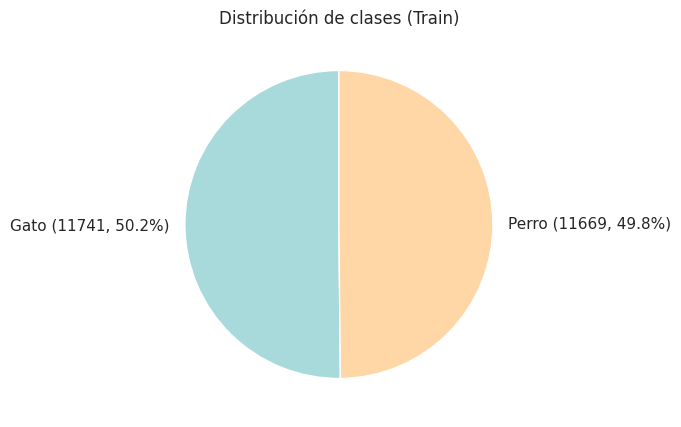

In [7]:
# Distribución de clases
sizes = [cats, dogs]
labels_torta = [f"Gato ({cats}, {cats/total*100:.1f}%)",
                f"Perro ({dogs}, {dogs/total*100:.1f}%)"]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels_torta, colors=[colors[0], colors[1]], startangle=90)
plt.title("Distribución de clases (Train)")
plt.show()

Las clases están correctamente balanceadas.

In [8]:
# Detectar imágenes corruptas y obtener tamaños
widths_cats, heights_cats = [], []
widths_dogs, heights_dogs = [], []
corrupt = 0

for img, label in zip(images, labels):
    try:
        img_pil = img if isinstance(img, Image.Image) else Image.open(img)
        w, h = img_pil.size
        if label == 0:
            widths_cats.append(w)
            heights_cats.append(h)
        else:
            widths_dogs.append(w)
            heights_dogs.append(h)
    except:
        corrupt += 1

print(f"Cantidad de imágenes corruptas: {corrupt}")

Cantidad de imágenes corruptas: 0


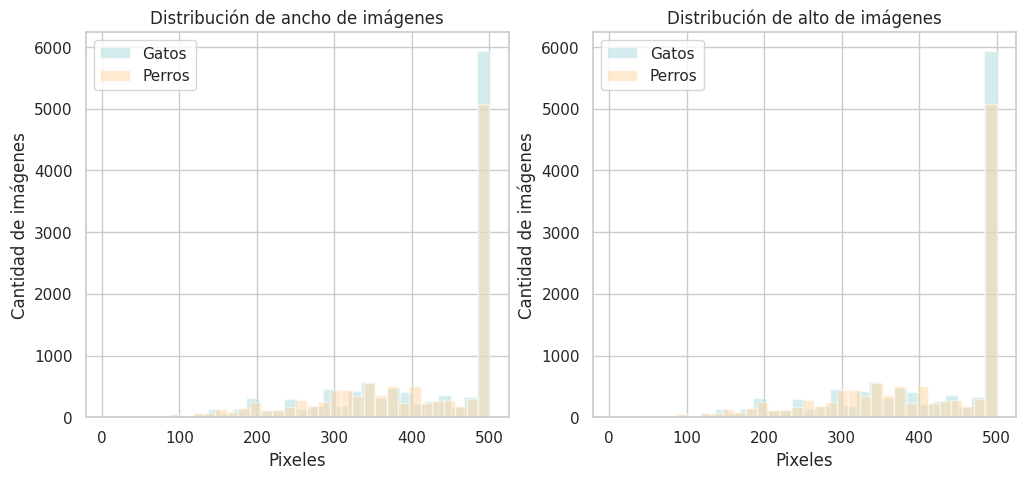

In [9]:
# Histogramas de ancho y alto por clase
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths_cats, bins=30, alpha=0.5, label='Gatos', color=colors[0])
plt.hist(widths_dogs, bins=30, alpha=0.5, label='Perros', color=colors[1])
plt.title("Distribución de ancho de imágenes")
plt.xlabel("Pixeles")
plt.ylabel("Cantidad de imágenes")
plt.legend()

plt.subplot(1,2,2)
plt.hist(widths_cats, bins=30, alpha=0.5, label='Gatos', color=colors[0])
plt.hist(widths_dogs, bins=30, alpha=0.5, label='Perros', color=colors[1])
plt.title("Distribución de alto de imágenes")
plt.xlabel("Pixeles")
plt.ylabel("Cantidad de imágenes")
plt.legend()
plt.show()


Las proporciones se ven similares entre clases.  
Las imágenes de gatos y perros tienen tamaños y relaciones ancho/alto parecidas.  
No hay un sesgo de tamaño que diferencie automáticamente las clases.  
Esto representa menor riesgo de que el modelo aprenda “atajos”.  
Si los tamaños fueran muy distintos, el modelo podría aprender a clasificar basado en tamaño en lugar de en características reales del objeto (ej., orejas, pelaje, forma).  
Al ser similares, el modelo necesita aprender rasgos visuales relevantes en lugar de depender del tamaño.  

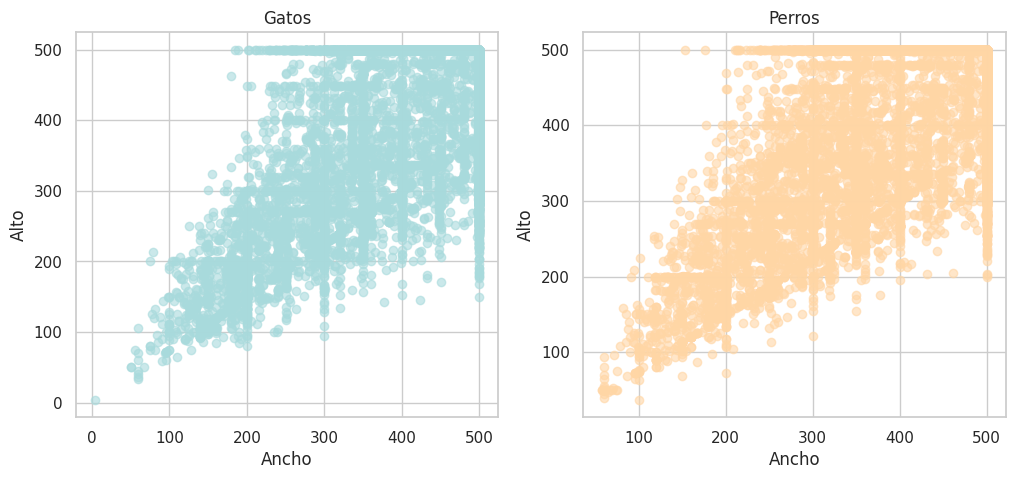

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(widths_cats, heights_cats, color=colors[0], alpha=0.6)
plt.title("Gatos")
plt.xlabel("Ancho")
plt.ylabel("Alto")

plt.subplot(1,2,2)
plt.scatter(widths_dogs, heights_dogs, color=colors[1], alpha=0.6)
plt.title("Perros")
plt.xlabel("Ancho")
plt.ylabel("Alto")
plt.show()


La distribución es similar en ambas clases.  
No hay un sesgo evidente de tamaño.  
Por lo que, el modelo no podrá diferenciar clases basándose únicamente en el tamaño o proporción de la imagen, si no que, necesitará aprender características visuales reales.  
Esto nos permite aplicar Resize + RandomResizedCrop o CenterCrop de la misma manera a ambas clases sin introducir sesgo.  
Las transformaciones aleatorias (flip, rotation, color jitter) funcionarán de manera similar en ambas clases.  
Esto hace que el dataset sea más balanceado y evita que el modelo aprenda patrones triviales.


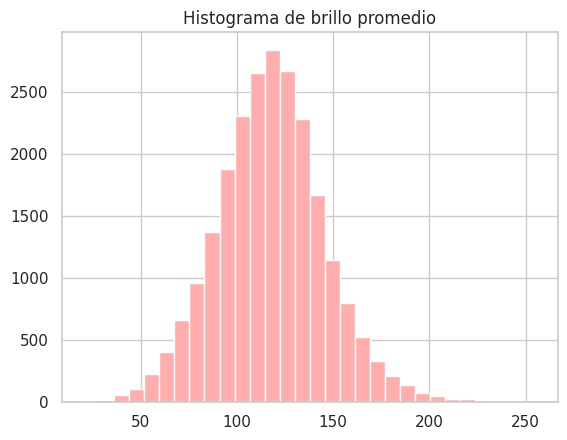

In [11]:
brightness = [np.array(img.convert('L')).mean() for img in images]
plt.hist(brightness, bins=30, color='#FFADAD')
plt.title("Histograma de brillo promedio")
plt.show()


Un histograma normal (campana de Gauss) indica que la mayoría de las imágenes tienen un brillo promedio medio, ni muy oscuro ni muy claro.  
Hay menos imágenes extremadamente oscuras o claras (colas de la distribución).  
Esto sugiere que el dataset tiene iluminación bastante uniforme y no está sesgado hacia imágenes oscuras o claras.  
Es buena señal, el modelo verá una variedad de brillos moderados, sin que haya muchas imágenes que sobresalgan demasiado.  
Reduce la necesidad de corrección masiva de iluminación.  

Ejemplos de Gatos:


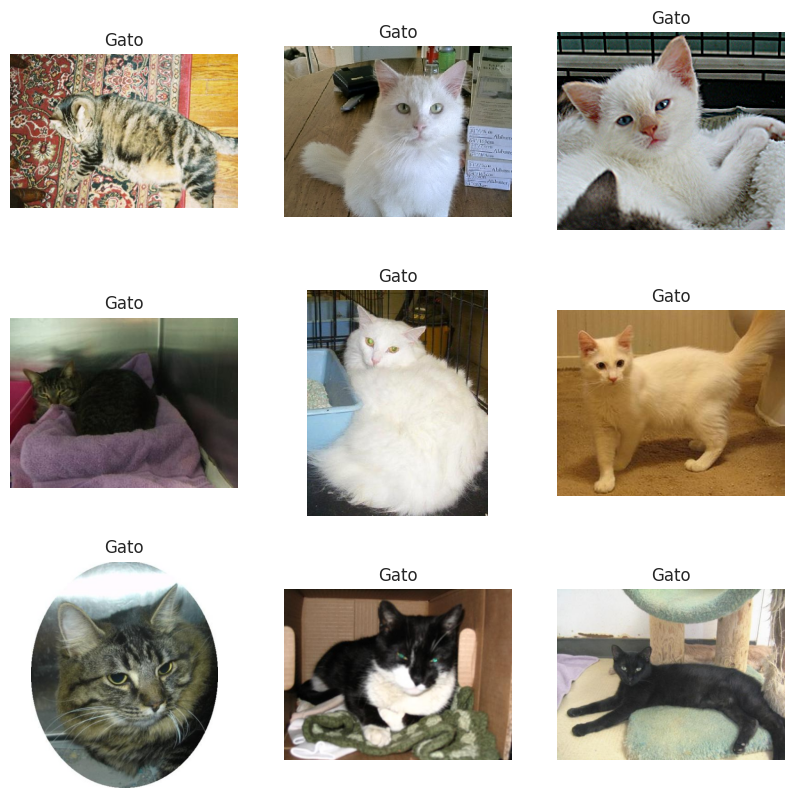




Ejemplos de Perros:


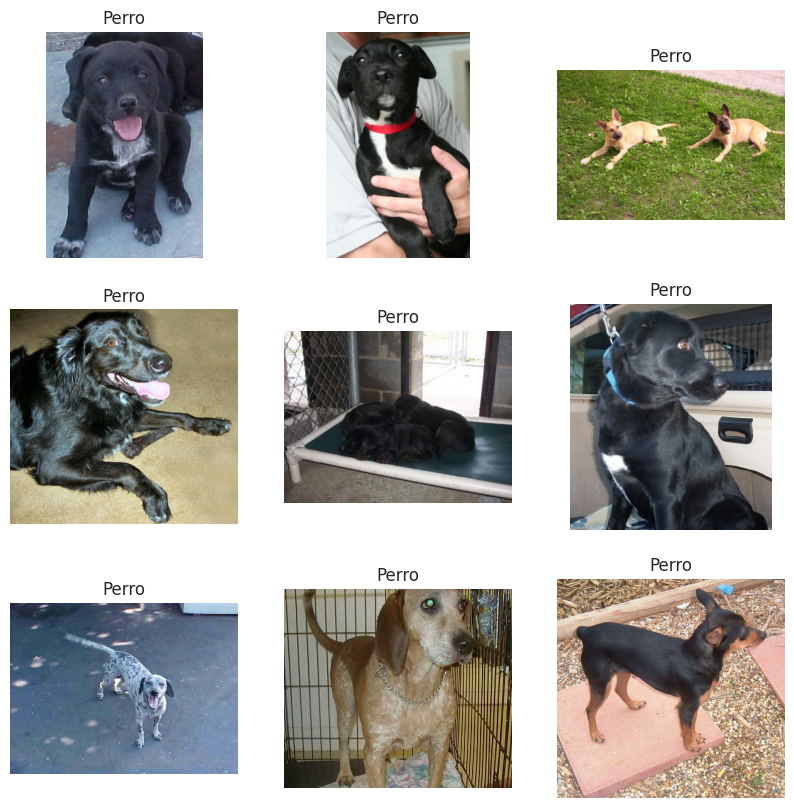

In [12]:
# Función para mostrar mosaicos de imágenes por clase
def mostrar_mosaico(images, labels, clase, n=9):
    idxs = [i for i, l in enumerate(labels) if l == clase]
    seleccion = random.sample(idxs, n)
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(seleccion):
        img = images[idx]
        img = img if isinstance(img, Image.Image) else Image.open(img)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(f"{'Perro' if clase==1 else 'Gato'}")
        plt.axis('off')
    plt.show()

print("Ejemplos de Gatos:")
mostrar_mosaico(images, labels, clase=0)
print ("\n\n")
print("Ejemplos de Perros:")
mostrar_mosaico(images, labels, clase=1)

In [13]:
# Seleccionar imégenes de ejemplo
idx_cat = [i for i, l in enumerate(labels) if l == 0]
idxs_dog = [i for i, l in enumerate(labels) if l == 1]

# Elegir un índice aleatorio de cada clase
idx_cat = random.choice(idx_cat)
idxs_dog = random.choice(idxs_dog)

# Obtener las imágenes correspondientes
img_cat = train_ds['image'][idx_cat]
img_cat = img_cat if isinstance(img_cat, Image.Image) else Image.open(img_cat)

img_dog = train_ds['image'][idxs_dog]
img_dog = img_dog if isinstance(img_dog, Image.Image) else Image.open(img_dog)

# Función para mostrar antes y después
def mostrar_transformacion(original, transform, title="Transformación"):
    img_transf = transform(original)

    # Convertir de tensor a PIL para mostrar
    if hasattr(img_transf, 'permute'):
        img_transf = transforms.ToPILImage()(img_transf)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img_transf)
    plt.title(title)
    plt.axis('off')

    plt.show()




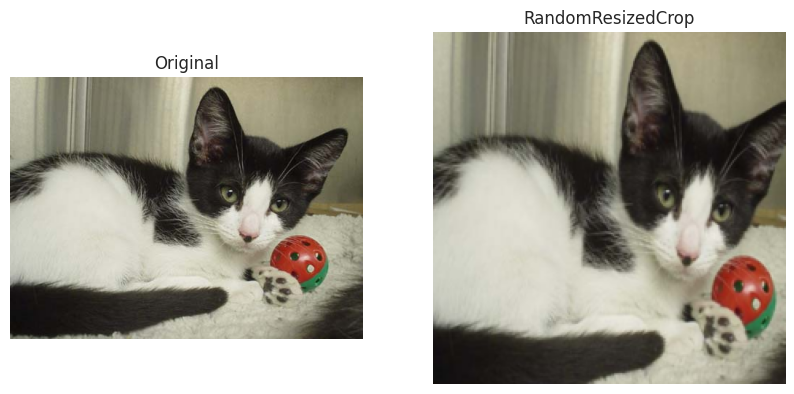

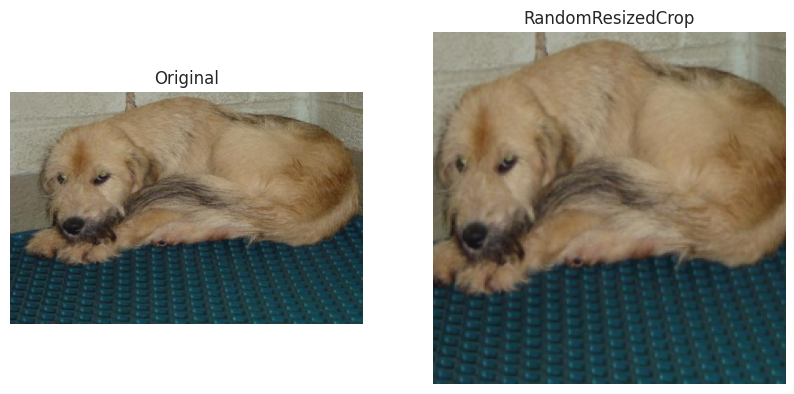

In [14]:
# RandomResizedCrop
IMG_SIZE = 224
SCALE_a = 0.8
SCALE_b = 1.0

# Permite que el modelo aprenda a reconocer el objeto
# aunque esté en distintas posiciones o escalas dentro de la imagen.
transform_crop = transforms.RandomResizedCrop(IMG_SIZE, scale=(SCALE_a, SCALE_b))

mostrar_transformacion(img_cat, transform_crop, title="RandomResizedCrop")
mostrar_transformacion(img_dog, transform_crop, title="RandomResizedCrop")


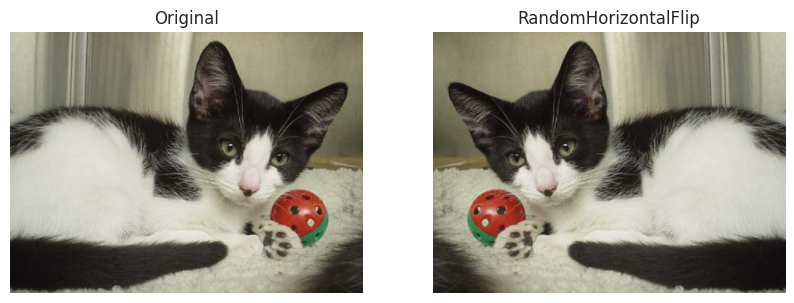

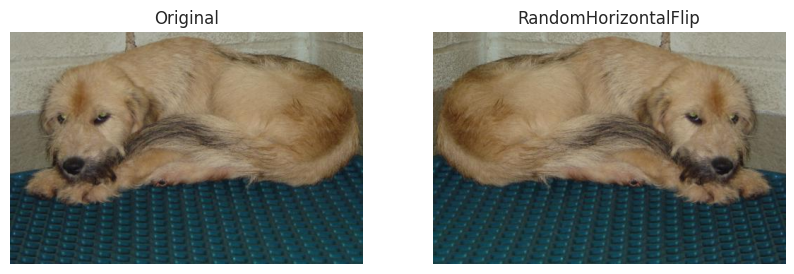

In [15]:
# RandomHorizontalFlip
transform_flip = transforms.RandomHorizontalFlip(p=1.0)  # 1.0 para mostrar el efecto seguro

# Los perros y gatos pueden aparecer mirando hacia cualquier lado;
# esta transformación aumenta la invariancia a orientación horizontal.
mostrar_transformacion(img_cat, transform_flip, title="RandomHorizontalFlip")
mostrar_transformacion(img_dog, transform_flip, title="RandomHorizontalFlip")

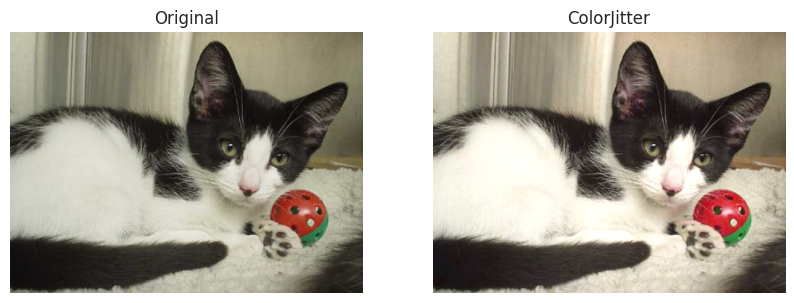

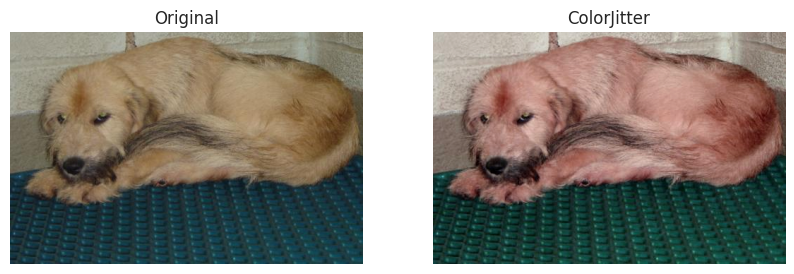

In [16]:
# ColorJitter
BRIGHTNESS=0.3
CONTRAST=0.3
SATURATION=0.3
HUE=0.1
transform_jitter = transforms.ColorJitter(brightness=BRIGHTNESS, contrast=CONTRAST, saturation=SATURATION, hue=HUE)

# Simula variaciones de iluminación y color, ayudando al modelo a generalizar frente a distintas condiciones de luz.
mostrar_transformacion(img_cat, transform_jitter, title="ColorJitter")
mostrar_transformacion(img_dog, transform_jitter, title="ColorJitter")

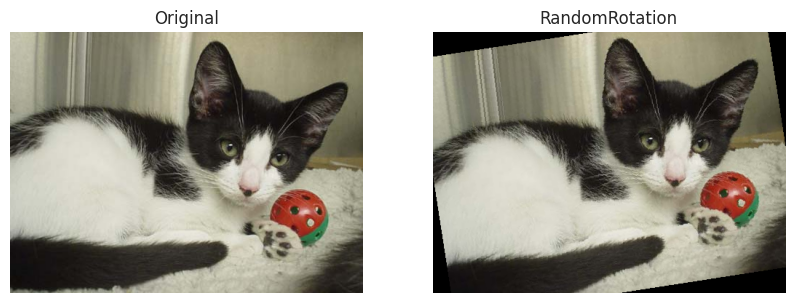

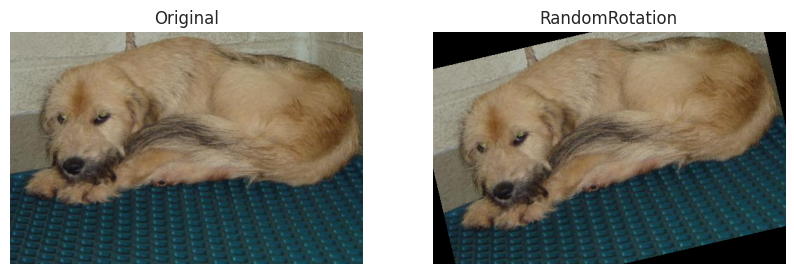

In [17]:
# RandomRotation
DEGREES = 15
transform_rot = transforms.RandomRotation(degrees=DEGREES)

# Permite cierta rotación de la imagen, útil si el objeto puede aparecer ligeramente inclinado, aumentando robustez del modelo.
mostrar_transformacion(img_cat, transform_rot, title="RandomRotation")
mostrar_transformacion(img_dog, transform_rot, title="RandomRotation")